In [1]:
import sys ; import os ; import platform ; from pathlib import Path ; import shutil
import warnings ; warnings.filterwarnings("ignore") ; warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd ; import numpy as np ; import matplotlib.pyplot as plt; import pyemu ; import flopy

In [2]:
sim_ws1   = tmp_d = Path('E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\models\\monthly_model_files_1lyr_newstress')  ; sim_name = "freyberg_mf6"
sim_ws    = Path("./RES_part2_01")                                                                           ; sim_ws.mkdir(exist_ok=True) 
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\00_bin\\mf6.exe'  ;  exe_name2  = 'E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\00_bin\\mp7.exe'

In [3]:
shutil.copytree(sim_ws1, sim_ws, dirs_exist_ok=True) ; sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws,verbosity_level=0) #; sim.set_sim_path(sim_ws) 
sim.run_simulation() ; pyemu.os_utils.run("mf6",cwd=sim_ws) ; pyemu.os_utils.run(r'mp7 freyberg_mp.mpsim', cwd=sim_ws) ;gwf = sim.get_model()

mf6.exe
mp7.exe freyberg_mp.mpsim


In [4]:
sr = pyemu.helpers.SpatialReference.from_namfile(os.path.join(sim_ws, "freyberg6.nam"),delr=gwf.dis.delr.array, delc=gwf.dis.delc.array); print(sr)
template_ws = os.path.join(sim_ws,"freyberg6_template")      ; start_datetime="1-1-2008"            # PEST Template
pf = pyemu.utils.PstFrom(original_d=sim_ws, new_d=template_ws, 
                         remove_existing=True, longnames=True, spatial_reference=sr, zero_based=False, start_datetime=start_datetime, echo=False) 

   could not remove start_datetime
xul:0; yul:10000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0


In [5]:
sys.path.insert(0,"..")
import herebedragons as hbd
hbd.prep_bins(template_ws)
hbd.prep_deps(sim_ws1)

In [6]:
df1 = pd.read_csv(os.path.join(template_ws,"heads.csv") ,index_col=0)                                ; df1.to_csv (sim_ws/"01_H.csv")  
df2 = pd.read_csv(os.path.join(template_ws,"sfr.csv")   ,index_col=0)                                ; df2.to_csv (sim_ws/"02_SFR.csv") 

hds_df1 = pf.add_observations ("heads.csv", insfile="heads.csv.ins", index_cols="time", use_cols=list(df1.columns.values), prefix="hds") 
sfr_df2 = pf.add_observations ("sfr.csv"  , insfile="sfr.csv.ins"  , index_cols="time", use_cols=list(df2.columns.values), prefix="sfr")  
p1_ins = [f for f in os.listdir(template_ws) if f.endswith(".ins")]; print('list', p1_ins)           ; hds_df1.to_csv (sim_ws/"03ab_hds_df1.csv")  ;

list ['heads.csv.ins', 'sfr.csv.ins']


#### **1 layer - transient** - Hydraulic properties **(Kh, Kv, Ss, Sy)** varing in space
#### **GHB** - BC1 - constant over time, but vary spatially
#### **SFR** - BC2 - inflow varies over time
#### **WEL** - BC3 - Pumping rates of individual wells are uncertain in space and and time

In [7]:
v_grid   = pyemu.geostats.ExpVario (contribution=1.0, a=1000  , anisotropy=1.0, bearing=0.0)  
v_pp     = pyemu.geostats.ExpVario (contribution=1.0, a=15000 , anisotropy=1.0, bearing=0.0 ) 
v_time   = pyemu.geostats.ExpVario (contribution=1.0, a=60    , anisotropy=1.0, bearing=0.0 ) 
grid_gs     = pyemu.geostats.GeoStruct (variograms=v_grid     , transform='log')
pp_gs       = pyemu.geostats.GeoStruct (variograms=v_pp       , transform='log') 
temporal_gs = pyemu.geostats.GeoStruct (variograms=v_time     , transform='none')

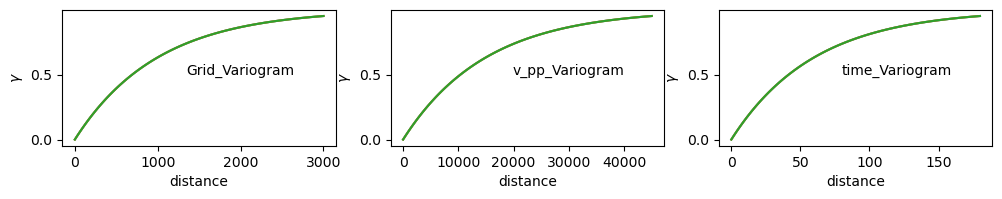

In [8]:
def beta_plot(ax):
    aa = grid_gs.plot(ax=ax1)  ; ab = pp_gs.plot  (ax=ax2)  ; ac = temporal_gs.plot(ax=ax3)
plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1, rowspan=1) ; ax1.text(2000,.5  ,"Grid_Variogram",ha="center",fontsize=10)
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1, rowspan=1) ; ax2.text(30000,.5 ,"v_pp_Variogram",ha="center",fontsize=10)
ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1, rowspan=1) ; ax3.text(120,.5   ,"time_Variogram",ha="center",fontsize=10)
beta_plot(ax1) ; beta_plot(ax2) ; beta_plot(ax3)

In [9]:
tag = "npf_k_"  ; files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]  ; print(files)
k1 = np.loadtxt(os.path.join(template_ws,'freyberg6.npf_k_layer1.txt')); print(k1.shape) ; k1 = pd.DataFrame(k1)    ; k1.to_csv (sim_ws/ "04_k1.csv") 

['freyberg6.npf_k_layer1.txt']
(40, 20)


<font color='blue'> **coarse scale** </font> constant K, single layer <font color='blue'> **coarse scale** </font> pilot points <font color='blue'> **coarse scale** </font> a unique K each cell

In [10]:
ib = gwf.dis.idomain.array[0]  #; plt.imshow(ib)  

In [11]:
f = 'freyberg6.npf_k_layer1.txt'
df_gr = pf.add_parameters(f,zone_array=ib, par_type="grid", geostruct=grid_gs, par_name_base=f.split('.')[1].replace("_","")+"gr", 
                          pargp=f.split('.')[1].replace("_","")+"gr", lower_bound=0.2, upper_bound=5.0, ult_ubound=100, ult_lbound=0.01 )
df_gr = pd.DataFrame(df_gr)    ; df_gr.to_csv (sim_ws/ "05a_df_gr.csv")  ; df_gr.head(2); #[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

In [12]:
df_pp = pf.add_parameters(f,zone_array=ib,par_type="pilotpoints",geostruct=pp_gs,par_name_base=f.split('.')[1].replace("_","")+"pp",
                          pargp=f.split('.')[1].replace("_","")+"pp",lower_bound=0.2,upper_bound=5.0,ult_ubound=100, ult_lbound=0.01,
                          pp_space=5) 
df_pp = pd.DataFrame(df_pp)    ; df_pp.to_csv (sim_ws/ "05b_df_pp.csv"); print('pilot points') 
# fig,ax = plt.subplots(1,1,figsize=(2,3)) ; ax.set_aspect("equal") ; ax.pcolormesh(sr.xcentergrid, sr.ycentergrid,ib) ; ax.scatter(df_pp.x,df_pp.y)
df_cst = pf.add_parameters(f,zone_array=ib,par_type="constant",geostruct=grid_gs,par_name_base=f.split('.')[1].replace("_","")+"cn",
                           pargp=f.split('.')[1].replace("_","")+"cn",lower_bound=0.2,upper_bound=5.0,ult_ubound=100, ult_lbound=0.01)
df_cst = pd.DataFrame(df_cst)    ; df_cst.to_csv (sim_ws/ "05c_df_cte.csv")

starting interp point loop for 706 points
starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 5.405222 seconds
pilot points


In [13]:
df = pf.add_observations(f,prefix="hk",zone_array=ib) ; df.to_csv (sim_ws/ "06_HK_as_observations.csv")

<font color='blue'> **parameterization** </font> ...again

In [14]:
def add_mult_pars(f, lb=0.2, ub=5.0, ulb=0.01, uub=100, add_coarse=True):
    if isinstance(f,str):    base  = f.split   (".")[1].replace("_","")
    else:                    base  = f[0].split(".")[1]
    pf.add_parameters(f,zone_array = ib,par_type="grid"  ,geostruct=grid_gs, par_name_base=base+"gr", pargp=base+"gr", lower_bound=lb, 
                      upper_bound  = ub, ult_ubound=uub  ,ult_lbound=ulb)
    pf.add_parameters(f,zone_array = ib,par_type="pilotpoints",geostruct=pp_gs,par_name_base=base+"pp",pargp=base+"pp",lower_bound=lb, 
                      upper_bound  = ub,ult_ubound=uub   ,ult_lbound=ulb ,pp_space=5) 
    if add_coarse==True:
        pf.add_parameters(f,zone_array=ib,par_type="constant",geostruct=grid_gs,par_name_base=base+"cn",pargp=base+"cn",lower_bound=lb, 
                          upper_bound=ub,ult_ubound=uub, ult_lbound=ulb)                       ; return

In [15]:
qde_PAR1 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print('PAR_groups_first_batch_K=',qde_PAR1)
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

PAR_groups_first_batch_K= 3


['npfklayer1cn_inst0_constant.csv.tpl',
 'npfklayer1gr_inst0_grid.csv.tpl',
 'npfklayer1pp_inst0pp.dat.tpl']

In [16]:
#tag = "sto_ss"       ; files =         [f for f in  os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
#for f in files[1:]:    add_mult_pars   (f, lb=0.2 , ub=5.0,   ulb=1e-7 ,uub=1e-3)
tag = "sto_sy"       ; files =         [f for f in  os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
f = files[0]         ; add_mult_pars   (f, lb=0.2 , ub=5.0,   ulb=0.01 ,uub=0.4)
tag = "ne_"          ; files =         [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:        add_mult_pars   (f, lb=0.2 , ub=5.0,   ulb=0.01 ,uub=0.4)

In [17]:
qde_PAR2 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR1,'+','PAR_groups_second_batch_sto(SsSy,)_ne_=',qde_PAR2)
#[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

3 + PAR_groups_second_batch_sto(SsSy,)_ne_= 15


<font color='blue'> **recharge | space and time uncertainties** </font> ... 1º cte in space varing in time; 2º cte in time varing in space 

In [18]:
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d')
dts2 = pd.DataFrame(dts)    ; dts2.to_csv (sim_ws/ "07_HK_Perlen.csv") 

In [19]:
tag = "rch_recharge"   ;   files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]    
dd = {s:f for s,f in zip(sp,files)}   ;  sp.sort()                  ; files = [dd[s] for s in sp]                                # dd
print(qde_PAR2,'+')                                  ; add_mult_pars (files, lb=0.2, ub=5.0, ulb=0, uub=1e-3, add_coarse=False)    # fron function

15 +


In [20]:
qde_PAR3 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR2,'+2', 'PAR_groups_third_batch_RCH1(space)=',qde_PAR3)
#[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

15 +2 PAR_groups_third_batch_RCH1(space)= 17


In [21]:
ffiles = pd.DataFrame(files) ; ffiles.tail(2)

,0
23,freyberg6.rch_recharge_24.txt
24,freyberg6.rch_recharge_25.txt


In [22]:
for f in files:   
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    pf.add_parameters(filenames=f  ,zone_array=ib,par_type="constant",par_name_base=f.split('.')[1]+"tcn",pargp=f.split('.')[1]+"tcn",
                      lower_bound=0.5, upper_bound=1.5,ult_ubound=1e-3, ult_lbound=0,datetime=dts[kper], geostruct=temporal_gs)

In [23]:
qde_PAR4 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR3,'+25  ''PAR_groups_fourth_batch_RCH_2(time)=',qde_PAR4)
#[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

17 +25  PAR_groups_fourth_batch_RCH_2(time)= 42


In [24]:
tag = "ghb_stress_period_data"    ; files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]; print(files)

['freyberg6.ghb_stress_period_data_1.txt']


In [25]:
tag = "ghb_stress_period_data"    ; files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    name = 'ghbcond'
    pf.add_parameters(f,par_type="grid",geostruct=grid_gs,par_name_base=name+"gr",pargp=name+"gr",index_cols=[0,1,2], use_cols=[4],
                      lower_bound=0.1,upper_bound=10.0)
    pf.add_parameters(f,par_type="constant",geostruct=grid_gs,par_name_base=name+"cn",pargp=name+"cn",index_cols=[0,1,2],use_cols=[4],
                      lower_bound=0.1,upper_bound=10.0,ult_lbound=0.01, ult_ubound=100) 
    name = 'ghbhead'
    pf.add_parameters(f,par_type="grid",geostruct=grid_gs,par_name_base=name+"gr",pargp=name+"gr",index_cols=[0,1,2],use_cols=[3],
                      lower_bound=-2.0,upper_bound=2.0,par_style="a", transform="none", ult_lbound=32.5, ult_ubound=42) 
    pf.add_parameters(f,par_type="constant",geostruct=grid_gs,par_name_base=name+"cn",pargp=name+"cn",index_cols=[0,1,2],use_cols=[3],
                      lower_bound=-2.0,upper_bound=2.0, par_style="a", transform="none",ult_lbound=32.5, ult_ubound=42) 

In [26]:
qde_PAR5 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR4,'+4  ''PAR_groups_fourth_batch_GHB=',qde_PAR5)
#[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

42 +4  PAR_groups_fourth_batch_GHB= 46


In [27]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]; ffiles = pd.DataFrame(files) ; ffiles.tail(2)

,0
23,freyberg6.wel_stress_period_data_8.txt
24,freyberg6.wel_stress_period_data_9.txt


In [28]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]      ; d = {s:f for s,f in zip(sp,files)}     ; sp.sort() ; files = [d[s] for s in sp]
for f in files:
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    pf.add_parameters(filenames=f,index_cols=[0,1,2]    ,use_cols=[3]       ,par_type="constant" ,par_name_base="welcst",pargp="welcst", 
                      upper_bound = 4, lower_bound=0.25 ,datetime=dts[kper] ,geostruct=temporal_gs)
    pf.add_parameters(filenames=f,index_cols=[0,1,2]    ,use_cols=[3]       , par_type="grid"    ,par_name_base="welgrd",pargp="welgrd", 
                      upper_bound = 4, lower_bound=0.25 ,datetime=dts[kper])

In [29]:
qde_PAR6 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR5,'+25|+25  ''PAR_groups_fifth_batch_Wel(cte|grid)=',qde_PAR6)
#[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

46 +25|+25  PAR_groups_fifth_batch_Wel(cte|grid)= 96


In [30]:
files = [f for f in os.listdir(template_ws) if "sfr_packagedata" in f.lower() and f.endswith(".txt")] ; assert len(files) == 1 ; # print(files)
f = files[0]  ; name = "sfrcond"
pf.add_parameters(f,par_type="grid",geostruct=grid_gs,par_name_base=name+"gr",pargp=name+"gr",index_cols=[0,2,3],use_cols=[9],
                  lower_bound=0.1,upper_bound=10.0)
pf.add_parameters(f,par_type="constant",geostruct=grid_gs,par_name_base=name+"cn",pargp=name+"cn",index_cols=[0,2,3],use_cols=[9],
                  lower_bound=0.1,upper_bound=10.0,ult_lbound=0.001, ult_ubound=100) 

,parnme,pargp,covgp,tpl_filename,input_filename,parval1,partype,partrans,parubnd,parlbnd,scale,parchglim,offset,dercom
pname:sfrcondcn_inst:0_ptype:cn_usecol:9_pstyle:m,pname:sfrcondcn_inst:0_ptype:cn_usecol:9_pstyle:m,sfrcondcn,sfrcondcn,RES_part2_01\freyberg6_template\sfrcondcn_inst0_constant.csv.tpl,RES_part2_01\freyberg6_template\mult\sfrcondcn_inst0_constant.csv,1.0,constant,log,10.0,0.1,1.0,factor,0.0,1


In [31]:
qde_PAR7 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR6,'+1+1  ''PAR_groups_sixth_batch_SFR=',qde_PAR7)
# [f for f in os.listdir(template_ws) if f.endswith(".tpl")]

96 +1+1  PAR_groups_sixth_batch_SFR= 98


In [32]:
files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]    ; d = {s:f for s,f in zip(sp,files)}   ; sp.sort()  ; files = [d[s] for s in sp]
for f in files:
    kper = int(f.split('.')[1].split('_')[-1]) - 1  
    pf.add_parameters(filenames=f,index_cols=[0], use_cols=[2],par_type="grid", 
                      par_name_base="sfrgr",pargp="sfrgr", upper_bound = 10, lower_bound=0.1, datetime=dts[kper], geostruct=temporal_gs)

In [33]:
qde_PAR8 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR7,'+1  ''PAR_groups_fifth_batch_Wel=',qde_PAR8)
# [f for f in os.listdir(template_ws) if f.endswith(".tpl")]

98 +1  PAR_groups_fifth_batch_Wel= 99


In [34]:
files = [f for f in os.listdir(template_ws) if "ic_strt" in f and f.endswith(".txt")]
files

['freyberg6.ic_strt_layer1.txt']

In [35]:
for f in files:
    base = f.split(".")[1].replace("_","")
    df = pf.add_parameters(f,par_type="grid",par_style="d",pargp=base,par_name_base=base,upper_bound=50,lower_bound=15,zone_array=ib,transform="none")
    df2 = pd.DataFrame(df)    ; df2.to_csv (sim_ws/ "08_IC.csv")  ; print('IC40x20x1-(inactives_ibound) x TDIS' ,df.shape) 

IC40x20x1-(inactives_ibound) x TDIS (706, 17)


In [36]:
df2.tail(2); 

In [37]:
qde_PAR9 = len([f for f in os.listdir(template_ws) if f.endswith(".tpl")]); print(qde_PAR8,'+1  ''PAR_groups_fifth_batch_IC=',qde_PAR9)
#[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

99 +1  PAR_groups_fifth_batch_IC= 100


<font color='blue'> **PEST "model"** </font> ... MODFLOW + PAR + OBS

In [38]:
pst = pf.build_pst()

noptmax:0, npar_adj:5410, nnz_obs:1106


In [39]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

['forward_run.py', 'RES_part2_01.pst']

# <font color='red'> **Second part!**  </font> ... after 38 commands and inspections ...

**A list of system commands which will be executed in sequence.**  Python functions that run before or after the system commands. 

In [40]:
pf.mod_sys_cmds.append("mf6") ; pf.mod_sys_cmds.append("mp7 freyberg_mp.mpsim") ; pf.mod_sys_cmds ; pst = pf.build_pst()

noptmax:0, npar_adj:5410, nnz_obs:1106


In [41]:
pf.add_py_function("helpers.py","extract_hds_arrays_and_list_dfs()",is_pre_cmd=False)

In [42]:
import helpers
helpers.test_extract_hds_arrays(template_ws)
files = [f for f in os.listdir(template_ws) if f.startswith("hdslay")]  # files
for f in files: pf.add_observations(f,prefix=f.split(".")[0],obsgp=f.split(".")[0])
for f in ["inc.csv","cum.csv"]:
    df = pd.read_csv(os.path.join(template_ws,f),index_col=0)
    pf.add_observations(f,index_cols=["totim"],use_cols=list(df.columns.values), prefix=f.split('.')[0],obsgp=f.split(".")[0])

In [43]:
helpers.process_secondary_obs(ws=template_ws)

Secondary observation files processed.


In [44]:
#[f for f in os.listdir(template_ws) if f.endswith(".csv")]

In [45]:
pf.add_py_function("helpers.py", "process_secondary_obs(ws='.')", is_pre_cmd=False) 

In [46]:
df = pd.read_csv(os.path.join (template_ws, "sfr.tdiff.csv"), index_col=0)
_  = pf.add_observations      ("sfr.tdiff.csv"  , insfile="sfr.tdiff.csv.ins"  , index_cols="time", use_cols=list(df.columns.values), prefix="sfrtd") 
df = pd.read_csv(os.path.join (template_ws, "heads.tdiff.csv"), index_col=0)
_  = pf.add_observations      ("heads.tdiff.csv", insfile="heads.tdiff.csv.ins", index_cols="time", use_cols=list(df.columns.values), prefix="hdstd") 
pst = pf.build_pst()          #_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

noptmax:0, npar_adj:5410, nnz_obs:21956


In [47]:
obs = pst.observation_data  ; obs.to_csv (sim_ws/ "09_OBS_2.csv") 

<font color='blue'> **OBS Weights, PAR bounds, ctrls     ...**  </font> *.ins, weights, PAR group INCTYP's and forecasts  `    `  OBS particles end time and status

In [48]:
out_file = "freyberg_mp.mpend" ; ins_file = out_file + ".ins"
with open(os.path.join(template_ws, ins_file),'w') as f:     f.write("pif ~\n")  ; f.write("l7 w w w w !part_status! w w !part_time!\n")

In [49]:
pst.add_observations(ins_file=os.path.join(template_ws, ins_file),out_file=os.path.join(template_ws, out_file),pst_path='.')
obs=pst.observation_data            ;obs.loc[obs.obsnme=='part_status', 'obgnme']='part'   ;obs.loc[obs.obsnme=='part_time','obgnme']='part' 
obs.to_csv (sim_ws/ "10_OBS_3.csv") 

2 obs added from instruction file RES_part2_01\freyberg6_template\.\freyberg_mp.mpend.ins


<font color='blue'> **Offset" PAR values and bounds... or...  use "absolute" increment types (INCTYP)**  </font> 
INCTYP 'absolute'. DERINC as 0.01 ... for this case.

In [50]:
head_pargps = [i for i in pst.adj_par_groups if 'head' in i]  ; head_pargps

['ghbheadgr', 'ghbheadcn']

In [51]:
pst.parameter_groups.loc[head_pargps, 'inctyp'] = 'absolute'
par = pst.parameter_data                        ; par_names = par.loc[par.parval1==0].parnme    # ; par.to_csv (sim_ws/ "11_PAR.csv") 
offset=-10 ;par.loc[par_names,'offset']=offset  ; par.loc[par_names,['parval1','parlbnd','parubnd']]-=offset   ; par.to_csv (sim_ws/ "11_PAR.csv") 

<font color='blue'> **Adding forecasts as "observations" in the control file** </font>  ...our interest this time: ... forecast:

 - groundwater level in the upper layer at row 9 and column 1 (site named "trgw-0-9-1") in stress period 22 (time=640);
 - the "tailwater" surface-water/groundwater exchange during stress period 13 (time=367); and
 - the "headwater" surface-water/groundwater exchange at stress period 22 (time=640).
 - the particle travel time.

In [52]:
forecasts =['oname:sfr_otype:lst_usecol:tailwater_time:4383.5'   ,'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
            'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5'  ,'part_time'] 
fobs = obs.loc[forecasts,:]   ; fobs2 = pd.DataFrame(fobs) ; fobs.to_csv (sim_ws/ "12_forecasts.csv")   ; pst.pestpp_options['forecasts'] = forecasts

In [53]:
pst.write(os.path.join(template_ws, 'freyberg_mf6.pst'),version=2)   

noptmax:0, npar_adj:5410, nnz_obs:21958


In [54]:
pst.control_data.noptmax

0

In [55]:
pyemu.os_utils.run('pestpp-glm freyberg_mf6.pst', cwd = template_ws)

pestpp-glm.exe freyberg_mf6.pst


In [57]:
iobj = pd.read_csv(os.path.join(template_ws, 'freyberg_mf6.iobj'))
iobj.total_phi

0    35365.7
Name: total_phi, dtype: float64

### Prior Parameter Covariance Matrix

One the major reasons `PstFrom` was built is to help with building the Prior - both covariance matrix and ensemble - with geostatistical correlation.  Remember all that business above related to geostatistical structures and correlations?  This is where it pays off.

Let's see how this works.  For cases with less than about 30,000 parameters, we can actually generate and visualize the prior parameter covariance matrix.  If you have more parameters, this matrix may not fit in memory.  But, not to worry, `PstFrom` has some trickery to help generate the geostatistical prior ensemble even in cases where the number of parameters is greater than 30,000. 


In [ ]:
if pf.pst.npar < 35000:  
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    try: 
        x = cov.x.copy()  ;  x[x==0] = np.NaN  
    except: pass

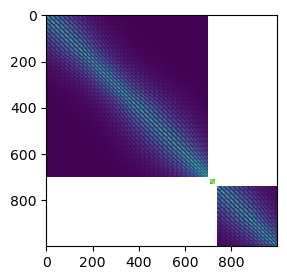

In [65]:
plt.figure(figsize=(5,3)) ; plt.imshow(x[:1000,:1000])

In [68]:
cov2 = cov.row_names[:] ; cov3 = pd.DataFrame(cov2)    ; cov3.to_csv (sim_ws/ "13_covariance_matix__prior.csv") 

In [71]:
pe=pf.draw(num_reals=1000, use_specsim=True)  ;pe.enforce() ;pe.to_binary(os.path.join(template_ws,"prior_pe.jcb")) ; assert pe.shape[1] == pst.npar

SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
SpecSim.initialize() summary: full_delx X full_dely: 72 X 72
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:1000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['ghbcondgr']
build cov matrix
done
getting diag var cov 10
scaling full cov by diag var cov
working on pargroups ['sfrcondgr']
build cov matrix
done
getting diag var cov 40
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:15000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npfklayer1pp']

,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:5,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:6,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:7,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:8,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:9,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:10,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:11,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:12,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:13,pname:ghbcondgr_inst:0_ptype:gr_usecol:4_pstyle:m_idx0:0_idx1:39_idx2:14,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:0_idx1:0_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:1_idx1:1_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:2_idx1:2_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:3_idx1:3_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:4_idx1:4_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:5_idx1:5_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:6_idx1:6_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:7_idx1:7_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:8_idx1:8_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:9_idx1:9_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:10_idx1:10_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:11_idx1:11_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:12_idx1:12_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:13_idx1:13_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:14_idx1:14_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:15_idx1:15_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:16_idx1:16_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:17_idx1:17_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:18_idx1:18_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:19_idx1:19_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:20_idx1:20_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:21_idx1:21_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:22_idx1:22_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:23_idx1:23_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:24_idx1:24_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:25_idx1:25_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:26_idx1:26_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:27_idx1:27_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:28_idx1:28_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:29_idx1:29_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:30_idx1:30_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:31_idx1:31_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:32_idx1:32_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:33_idx1:33_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:34_idx1:34_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:35_idx1:35_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:36_idx1:36_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:37_idx1:37_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:38_idx1:38_idx2:15,pname:sfrcondgr_inst:0_ptype:gr_usecol:9_pstyle:m_idx0:39_idx1:39_idx2:15,pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:2_zone:1,pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:7_zone:1,pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:12_zone:1,pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:17_zone:1,pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:7_j:2_zone:1,pname:npfklayer1pp_inst:0_ptype:pp_ps

Let's now test-run one of these geostatistical realizations (always a good idea!).  We do this by replacing the `parval1` values in the control with a row from `pe`:

In [82]:
#pe2 = pe[:10]
pe2 = pd.DataFrame(pe)     
#pe[20].to_csv (sim_ws/ "14_Best_PAR_IN_1.csv") 


In [ ]:
pst.parameter_data.loc[:,"parval1"] = pe.loc[pe.index[0],pst.par_names].values
pst.parameter_data.parval1.values

In [ ]:
pst.control_data.noptmax = 0
pst.write(os.path.join(template_ws,"test.pst"),version=2)
pyemu.os_utils.run("pestpp-glm test.pst",cwd=template_ws)

If all went well, that's it! The PEST-interface is setup, tested and we have our prior prepared. We should be good to go!

### Bonus: Understanding Multiplier-Parameters

Now the multiplier files in the `template_ws/mult` folder and the MF6 input files in the `template_ws` folder contain the values corresponding to this realization, so we can visualize the multiplier parameter process:

In [ ]:
df = pd.read_csv(os.path.join(template_ws,"mult2model_info.csv"))
kh1_df = df.loc[df.model_file.str.contains("npf_k_layer1"),:]
kh1_df

In [ ]:
org_arr = np.loadtxt(os.path.join(template_ws,kh1_df.org_file.iloc[0]))
inp_arr = np.loadtxt(os.path.join(template_ws,kh1_df.model_file.iloc[0]))
mlt_arrs = [np.loadtxt(os.path.join(template_ws,afile)) for afile in kh1_df.mlt_file]
arrs = [org_arr]
arrs.extend(mlt_arrs)
arrs.append(inp_arr)
names = ["org"]
names.extend([mf.split('.')[0].split('_')[-1] for mf in kh1_df.mlt_file])
names.append("MF6 input")
fig,axes = plt.subplots(1,kh1_df.shape[0]+2,figsize=(5*kh1_df.shape[0]+2,5))
for i,ax in enumerate(axes.flatten()):
    arr = np.log10(arrs[i])
    arr[ib==0] = np.NaN
    cb = ax.imshow(arr)
    plt.colorbar(cb,ax=ax)
    ax.set_title(names[i],loc="left")
plt.tight_layout()    
    

So now we can see the difference the pilot point geostructure makes compared to the grid-scale geostructure.  The pilot point array has a much stronger spatial correlation (over a larger distance) than the grid-scale...

# Finally, what's up with all these new files and folders? We can trace through them to see how multipliers are applied

In [ ]:
from IPython.display import Image, display
display(Image(url='./pest_flow2.gif'))